# K-Fold CV for Boosting Methods Using SKLearn 

In [3]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random
from scipy.stats import randint

In [4]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [6]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.14it/s]


In [7]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [8]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [9]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',
       'Rhythm', 'Subject'],
      dtype='object')


# Extreme Gradient Boosting

In [ ]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []
x_values = ['AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    temp_model = XGBClassifier(learning_rate = 0.1, use_label_encoder =False,verbose=None, eval_metric='logloss')
    param_distributions = {'n_estimators': randint(105, 110),
                           'max_depth': randint(7,10)}
    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)

    n_estimators_list.append(search.best_params_['n_estimators'])
    max_depth_list.append(search.best_params_['max_depth'])    

    model = XGBClassifier(n_estimators=search.best_params_['n_estimators'], learning_rate=0.1,use_label_encoder=False,verbose=None, max_depth=search.best_params_['max_depth'], eval_metric='logloss')
    model.fit(X_train, y_train)
    #model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [9]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(n_estimators_list)
print(max_depth_list)
# roc_auc_score 0.9998973587609896
# ---Run time is 1518.3390728000086 seconds ---

# Accuracy of each fold: 
#  [0.9187643020594966, 0.9545638945233266, 0.9955919395465995, 0.9292565947242206, 0.9973876698014629, 0.9586206896551724, 0.7772069126576366, 0.9979577944179714, 0.9397590361445783, 0.9702315325248071, 0.9823049001814882, 0.9892318736539842, 0.8290249433106576, 0.954140127388535, 0.601165695253955, 0.9871510855117412, 0.9897189856065799, 0.983266012694749, 0.7472527472527473, 0.9620670698185816, 0.9970059880239521, 0.9949780288763339, 0.9987315010570824]

# Avg accuracy : 
# 0.9328425793341589

# Std of accuracy : 
# 0.0983715891713939
# [[23093  1650]
#  [ 1709 18516]]

[[23380  1363]
 [ 1332 18893]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24743
           1       0.93      0.93      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9227688787185355, 0.9610547667342799, 0.9962216624685138, 0.8405275779376499, 0.990073145245559, 0.9699797160243407, 0.749182624941616, 0.9965963240299524, 0.9352409638554217, 0.9680264608599779, 0.9813974591651543, 0.9877961234745154, 0.7986394557823129, 0.9738853503184713, 0.8068276436303081, 0.9707576428887904, 0.9924605894448252, 0.9976918638199653, 0.915469146238377, 0.9846069268829027, 0.9931565440547476, 0.9912115505335845, 0.9898520084566597]
3500.3249152999997
[105, 109, 109, 105, 106, 109, 106, 109, 105, 108, 109, 109, 109, 108, 109, 105, 109, 105, 105, 108, 105, 107, 108]
[7, 7, 7, 9, 9, 7, 9, 7, 7, 8, 7, 8, 7, 8, 7, 9, 

In [33]:
temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.95:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(n_estimators_list[idx])
    print(max_depth_list[idx])
#temp_idx
#[[23100  1643]
# [ 1651 18574]]
# ---Run time is 1892.6001277000178 seconds ---

# Accuracy of each fold: 
#  [0.9187643020594966, 0.9545638945233266, 0.9955919395465995, 0.9322541966426858, 0.9973876698014629, 0.9578093306288032, 0.7772069126576366, 0.9979577944179714, 0.9397590361445783, 0.9663726571113561, 0.9823049001814882, 0.9899497487437185, 0.8326530612244898, 0.954140127388535, 0.6261448792672772, 0.9893664155959238, 0.9904043865661412, 0.983266012694749, 0.7468300929839391, 0.9620670698185816, 0.9970059880239521, 0.9943502824858758, 0.9970401691331924]

# Avg accuracy : 
# 0.9340517768539904

# Std of accuracy : 
# 0.0945901788927137

108
8
106
9
105
9
106
9
108
8
109
8
109
7
108
8
105
7
106
9
109
7
106
9
108
8
109
8
107
8
106
9


In [10]:
import statistics
print(statistics.mode(n_estimators_list))
print(statistics.mode(max_depth_list))

109
7


In [19]:
len(good_list)

23

# All

In [8]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

df = features_maindf

x_values = ['AppEn','SampEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

#     temp_model = XGBClassifier(learning_rate = 0.1, use_label_encoder =False,verbose=None, eval_metric='logloss')
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])    

    model = XGBClassifier(n_estimators=109, learning_rate=0.1,use_label_encoder=False,verbose=None, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    #model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 


    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100
    

    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')


for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23
        

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

average_importance['Importance'] /= 23

perm_imp_dict["XGBoost"] = 100
perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)

#perm_imp_df_t.to_csv('perm_imp.csv',mode='a',header=False)

perm_imp_df_t = perm_imp_df_t.drop(["XGBoost"])


1.5.1
roc_auc_score 0.9517822897324283
roc_auc_score 0.9851934667586841
roc_auc_score 0.9988427065891854
roc_auc_score 0.9771896552855559
roc_auc_score 0.9995218021262513
roc_auc_score 0.9916393619148707
roc_auc_score 0.9128328845002993
roc_auc_score 0.9945355191256832
roc_auc_score 0.9675931966960397
roc_auc_score 0.9957565894538319
roc_auc_score 0.9202604537826716
roc_auc_score 0.9628932968536251
roc_auc_score 0.9385624351082612
ROC_AUC not able to be calculated for subject 07162
ROC_AUC not able to be calculated for subject 07859
roc_auc_score 0.9950516673915231
roc_auc_score 0.9989938635018533
roc_auc_score 1.0
roc_auc_score 0.9752246708084242
roc_auc_score 0.9995212343798701
roc_auc_score 0.9989922717103925
roc_auc_score 0.9986953405017921
roc_auc_score 0.9998124464632628
---Run time is 92.19804810000005 seconds ---

Accuracy of each fold: 
 [0.9233409610983981, 0.9610547667342799, 0.9962216624685138, 0.8339328537170264, 0.9890282131661442, 0.9699797160243407, 0.7603923400280242, 

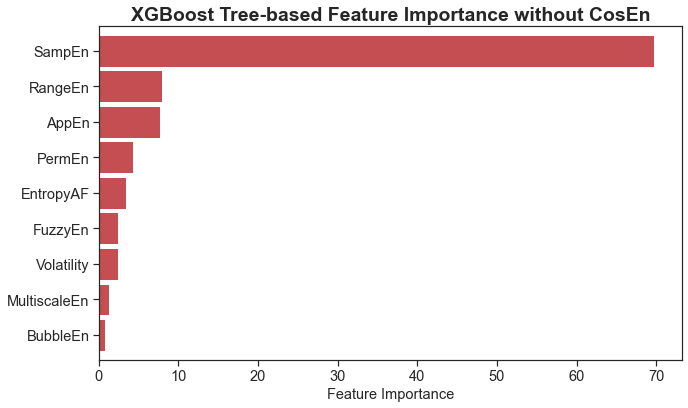

In [9]:
# Prepare your data

import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("XGBoost Tree-based Feature Importance without CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

In [84]:
perm_imp_df_t = perm_imp_df_t.drop(["XGBoost"])

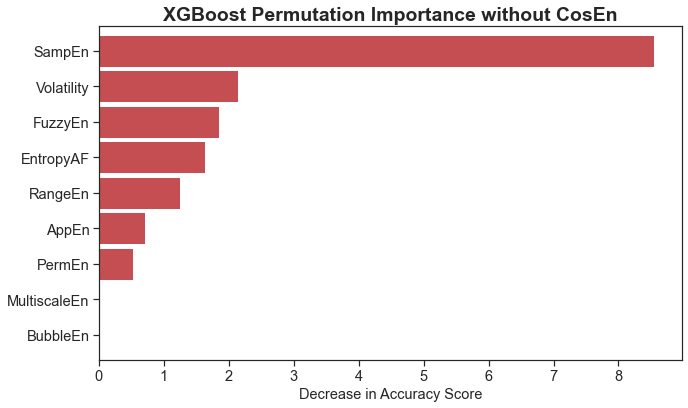

In [10]:
import matplotlib as mpl
df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = "Arial"

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("XGBoost Permutation Importance without CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


# CosEn

In [10]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

df = features_maindf

x_values = ['AppEn','CosEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

#     temp_model = XGBClassifier(learning_rate = 0.1, use_label_encoder =False,verbose=None, eval_metric='logloss')
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])    

    model = XGBClassifier(n_estimators=109, learning_rate=0.1,use_label_encoder=False,verbose=None, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    #model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 


    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100
    

    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')


for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23
        

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))


average_importance['Importance'] /= 23

1.5.1
roc_auc_score 0.9517822897324283
roc_auc_score 0.9851934667586841
roc_auc_score 0.9988427065891854
roc_auc_score 0.9771896552855559
roc_auc_score 0.9995218021262513
roc_auc_score 0.9916393619148707
roc_auc_score 0.9128328845002993
roc_auc_score 0.9945355191256832
roc_auc_score 0.9675931966960397
roc_auc_score 0.9957565894538319
roc_auc_score 0.9202604537826716
roc_auc_score 0.9628932968536251
roc_auc_score 0.9385624351082612
ROC_AUC not able to be calculated for subject 07162
ROC_AUC not able to be calculated for subject 07859
roc_auc_score 0.9950516673915231
roc_auc_score 0.9989938635018533
roc_auc_score 1.0
roc_auc_score 0.9752246708084242
roc_auc_score 0.9995212343798701
roc_auc_score 0.9989922717103925
roc_auc_score 0.9986953405017921
roc_auc_score 0.9998124464632628
---Run time is 91.8884588 seconds ---

Accuracy of each fold: 
 [0.9233409610983981, 0.9610547667342799, 0.9962216624685138, 0.8339328537170264, 0.9890282131661442, 0.9699797160243407, 0.7603923400280242, 0.99659

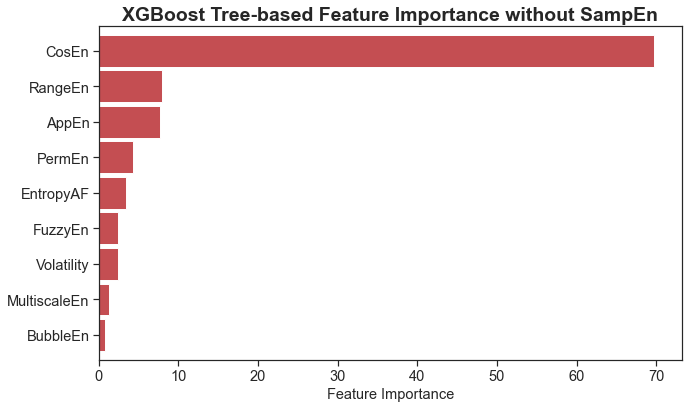

In [11]:
# Prepare your data

import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("XGBoost Tree-based Feature Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

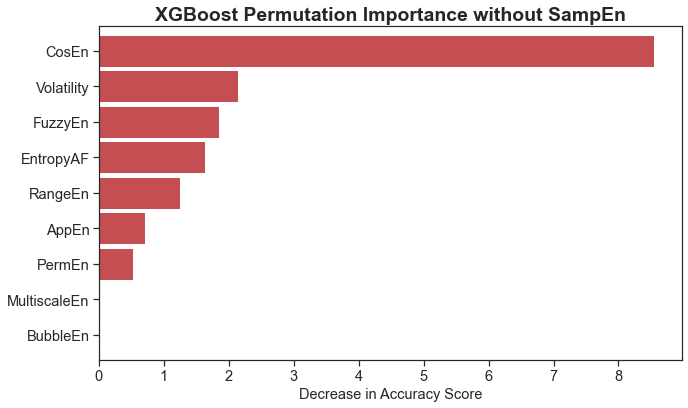

In [12]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = "Arial"

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("XGBoost Permutation Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()

# No Samp or CosEn

In [18]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

df = features_maindf

x_values = ['AppEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

#     temp_model = XGBClassifier(learning_rate = 0.1, use_label_encoder =False,verbose=None, eval_metric='logloss')
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])    

    model = XGBClassifier(n_estimators=109, learning_rate=0.1,use_label_encoder=False,verbose=None, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    #model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 


    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100
    

    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')


for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23
        

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

1.5.1
roc_auc_score 0.9530607896258866
roc_auc_score 0.9854299516908211
roc_auc_score 0.9985472274204669
roc_auc_score 0.9716576873355339
roc_auc_score 0.9995647326086826
roc_auc_score 0.9902106696201948
roc_auc_score 0.9089860680412745
roc_auc_score 0.9916666666666667
roc_auc_score 0.9671994281695768
roc_auc_score 0.9958326362378136
roc_auc_score 0.9117146732259028
roc_auc_score 0.9674247606019152
roc_auc_score 0.9302772718073264
ROC_AUC not able to be calculated for subject 07162
ROC_AUC not able to be calculated for subject 07859
roc_auc_score 0.99584362851136
roc_auc_score 0.9989346790019624
roc_auc_score 1.0
roc_auc_score 0.974887664595788
roc_auc_score 0.9994135924451428
roc_auc_score 0.9989099044132602
roc_auc_score 0.9985161290322581
roc_auc_score 0.9996734142395124
---Run time is 93.31582379999998 seconds ---

Accuracy of each fold: 
 [0.915903890160183, 0.9622718052738337, 0.993073047858942, 0.8177458033573142, 0.9864158829676071, 0.9667342799188641, 0.7445119103222793, 0.995

<AxesSubplot:>

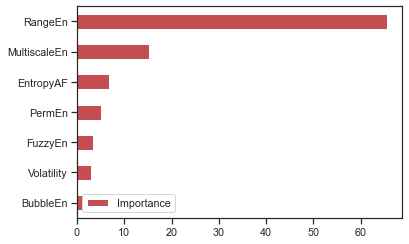

In [101]:
average_importance['Importance'] /= 23

# Now you can sort and plot the average importances
average_importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')

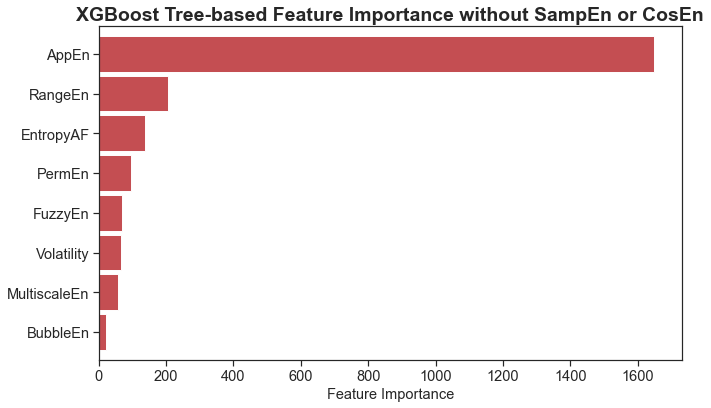

In [19]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("XGBoost Tree-based Feature Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


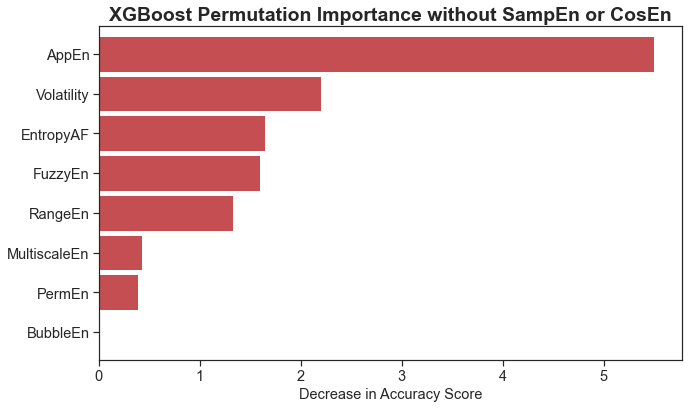

In [20]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("XGBoost Permutation Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0)
plt.tight_layout()
plt.show()

In [40]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# Accuracy of each fold: 
#  [0.9187643020594966, 0.9549695740365112, 0.9962216624685138, 0.9322541966426858, 0.9973876698014629, 0.9574036511156186, 0.7706679121905652, 0.9979577944179714, 0.9407630522088354, 0.9658213891951488, 0.9832123411978222, 0.9899497487437185, 0.8303854875283446, 0.954140127388535, 0.6219816819317235, 0.9880372175454143, 0.9904043865661412, 0.9838430467397576, 0.7616229923922232, 0.959868059373282, 0.9965782720273738, 0.9943502824858758, 0.9978858350951374]

# Avg accuracy : 
# 0.9341074210066155

# Std of accuracy : 
# 0.09454601994721872
#n_estimators = 106, depth = 8
#[[23124  1619]
#[ 1670 18555]]

[[23124  1619]
 [ 1670 18555]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.92      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.93      0.93      0.93     44968
weighted avg       0.93      0.93      0.93     44968

[0.9187643020594966, 0.9549695740365112, 0.9962216624685138, 0.9322541966426858, 0.9973876698014629, 0.9574036511156186, 0.7706679121905652, 0.9979577944179714, 0.9407630522088354, 0.9658213891951488, 0.9832123411978222, 0.9899497487437185, 0.8303854875283446, 0.954140127388535, 0.6219816819317235, 0.9880372175454143, 0.9904043865661412, 0.9838430467397576, 0.7616229923922232, 0.959868059373282, 0.9965782720273738, 0.9943502824858758, 0.9978858350951374]
47.04468490020372


1.5.1


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


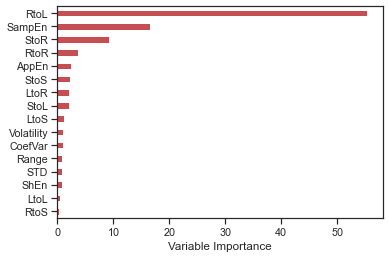

roc_auc_score 0.9764999543392895


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


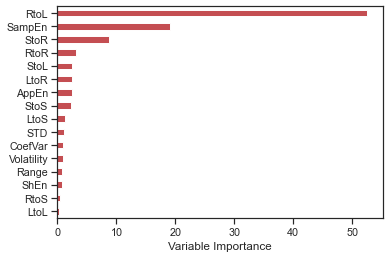

roc_auc_score 0.9857078444904531


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


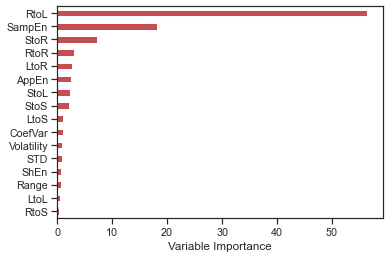

roc_auc_score 0.9992859253422633


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


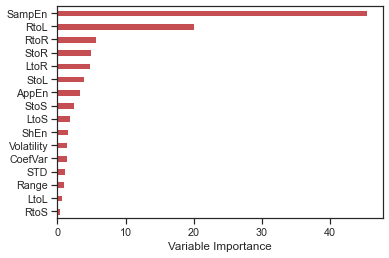

roc_auc_score 0.987531744833877


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


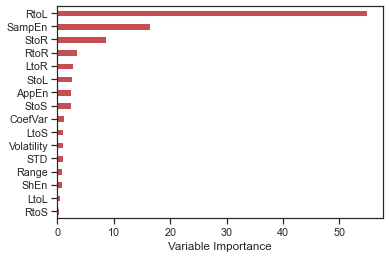

roc_auc_score 0.9999988074865991


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


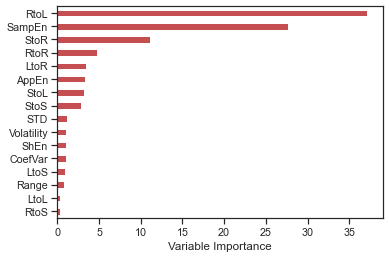

roc_auc_score 0.9924046641130955


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


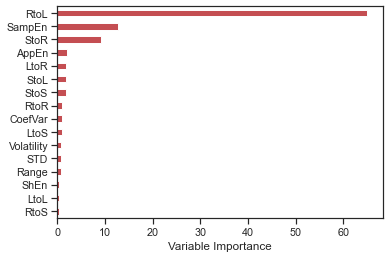

roc_auc_score 0.8915286165061749


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


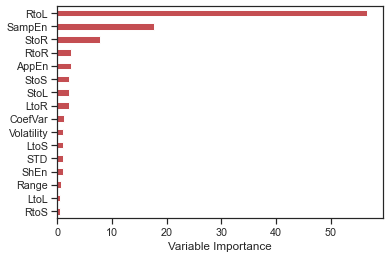

roc_auc_score 0.9990437158469946


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


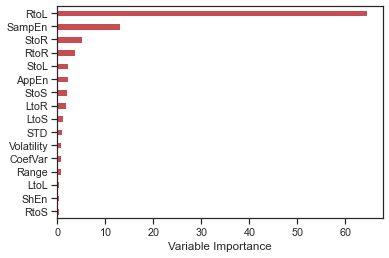

roc_auc_score 0.973566122511666


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


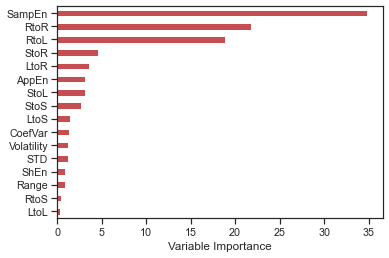

roc_auc_score 0.9952546806795541


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


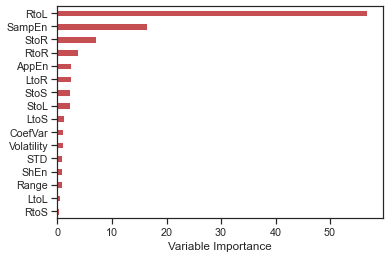

roc_auc_score 0.9363290499068987


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


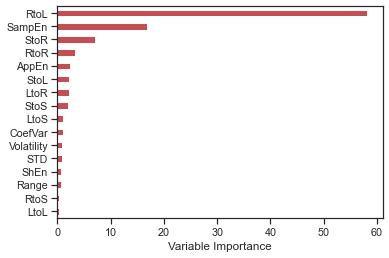

roc_auc_score 0.9649880300957592


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


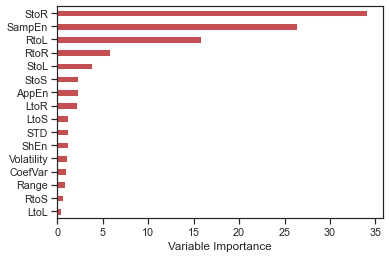

roc_auc_score 0.9629530903687908


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


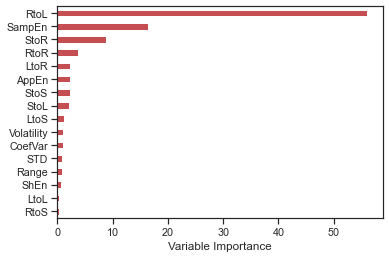

ROC_AUC not able to be calculated for subject 07162


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


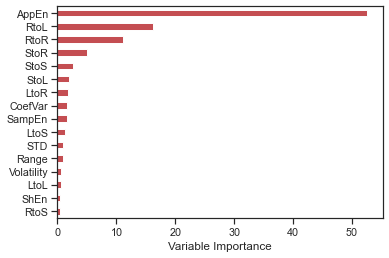

ROC_AUC not able to be calculated for subject 07859


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


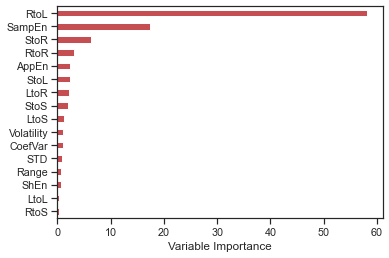

roc_auc_score 0.9984787509424717


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


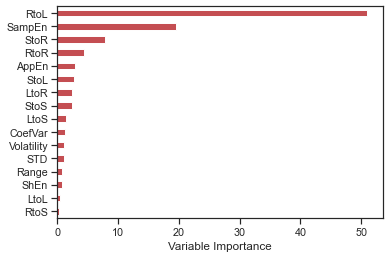

roc_auc_score 0.9988412297916083


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


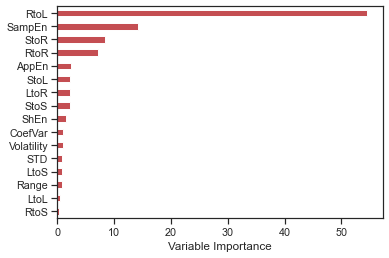

roc_auc_score 0.9993739797162042


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


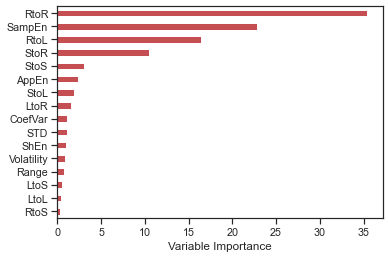

roc_auc_score 0.9585936584222248


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


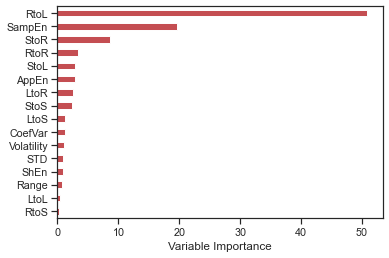

roc_auc_score 0.9939800846354794


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


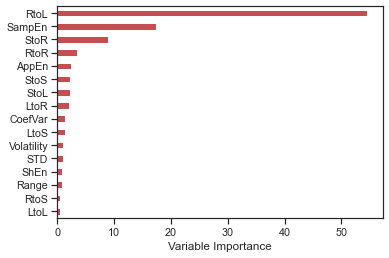

roc_auc_score 0.9992007321537523


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


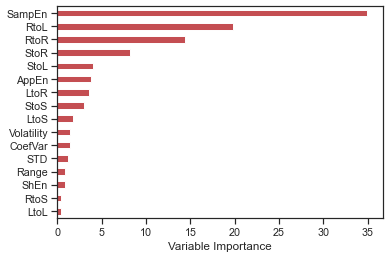

roc_auc_score 0.9999283154121863


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


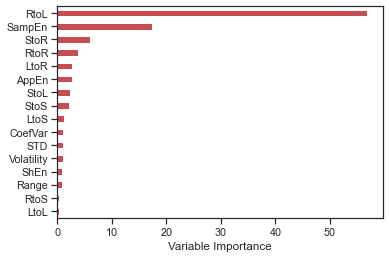

roc_auc_score 0.9999020242718537
---Run time is 28.772993899998255 seconds ---

Accuracy of each fold: 
 [0.914187643020595, 0.954158215010142, 0.9962216624685138, 0.935251798561151, 0.9968652037617555, 0.9525354969574037, 0.7888836992059786, 0.998638529611981, 0.9392570281124498, 0.9685777287761852, 0.9823049001814882, 0.990667623833453, 0.8249433106575964, 0.9535031847133758, 0.5961698584512906, 0.9906956136464333, 0.9910897875257025, 0.9878822850548182, 0.742603550295858, 0.9692138537658054, 0.9961505560307955, 0.9968612680477087, 0.9987315010570824]

Avg accuracy : 
0.9332780129890246

Std of accuracy : 
0.09926188579723327


In [7]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

#     temp_model = XGBClassifier(learning_rate = 0.1, use_label_encoder =False,verbose=None, eval_metric='logloss')
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])    

    model = XGBClassifier(learning_rate=0.1,use_label_encoder=False,verbose=None, max_depth=5, eval_metric='logloss')
    model.fit(X_train, y_train)
    #model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [13]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

confusion_matrix = pd.DataFrame(confusion_matrix(Truth, Output))
acc_score1 = pd.DataFrame([acc_score])

confusion_matrix.to_csv("model_results/XGBoost_cm.csv",index=False)
acc_score1 = pd.DataFrame([acc_score])
acc_score1 = acc_score1.T
acc_score1.columns = ["Accuracy"]
acc_score1.to_csv("model_results/XGBoost_accuracy.csv",index=False)

[[23356  1387]
 [ 1300 18925]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24743
           1       0.93      0.94      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9233409610983981, 0.9610547667342799, 0.9962216624685138, 0.8339328537170264, 0.9890282131661442, 0.9699797160243407, 0.7603923400280242, 0.9965963240299524, 0.9352409638554217, 0.9680264608599779, 0.9813974591651543, 0.9849246231155779, 0.7986394557823129, 0.9694267515923567, 0.8068276436303081, 0.974745237040319, 0.9924605894448252, 0.9988459319099827, 0.9142011834319527, 0.9835074216602528, 0.9931565440547476, 0.9905838041431262, 0.9906976744186047]
93.3915419


In [133]:
confusion_matrix.to_csv("model_results/XGBoost_cm.csv",index=False)

In [134]:
acc_score1.to_csv("model_results/XGBoost_accuracy.csv",index=False)

In [124]:
acc_score1 = pd.DataFrame([acc_score])

In [129]:
acc_score1 = acc_score1.T


In [130]:
acc_score1.columns = ["Accuracy"]
acc_score1

confu

,Accuracy
0,0.921625
1,0.962677
2,0.995592
3,0.840528
4,0.989551
5,0.971197
6,0.757590
7,0.995235
8,0.935743
9,0.967475
